In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.auto import tqdm
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
def combine_df(root_dir, metadata_path):
    dfs = []
    meta_df = pd.read_csv(metadata_path)
    for i in range(meta_df.shape[0]):
        csv_path = meta_df.iloc[i]['Location'] + '.csv'
        measure_df = pd.read_csv(root_dir + csv_path)
        measure_df['Latitude'] = meta_df.iloc[i]['Latitude']
        measure_df['Longitude'] = meta_df.iloc[i]['Longitude']
        dfs.append(measure_df)
    df = pd.concat(dfs, axis=0)
    df.fillna(method='ffill', limit=10, inplace=True)
    # df.fillna(method='bfill', limit=10, inplace=True)
    df.fillna(df.mean(numeric_only=True), inplace=True)
    return df

root = '/content/drive/MyDrive/Colab Notebooks/AF_pj/dataset/' # tutujin
# root = '/content/drive/MyDrive/Colab Notebooks/dataset/' # jin
# root = '/content/drive/MyDrive/Colab Notebooks/AF_dataset/' # 엄마
# root = '/content/drive/MyDrive/Project/dataset/' # 효정언니
pm_df = combine_df(root+'TRAIN/', root+'META/pmmap.csv')
aws_df = combine_df(root+'TRAIN_AWS/', root+'META/awsmap.csv')
pm_test_df = combine_df(root+'TEST_INPUT/', root+'META/pmmap.csv')
aws_test_df = combine_df(root+'TEST_AWS/', root+'META/awsmap.csv')
pm_label = list(pm_df['측정소'].unique())

In [4]:
near_pmaws = {'아름동': '세종고운', '신흥동': '세종연서', '노은동': '계룡', '문창동': '오월드', 
              '읍내동': '장동', '정림동': '오월드', '공주': '공주', '논산': '논산', '대천2동': '대천항', 
              '독곶리': '대산', '동문동': '태안', '모종동': '아산', '신방동': '성거', '예산군': '예산', 
              '이원면': '태안', '홍성읍': '홍북', '성성동': '성거'}
df = pm_df.copy()
cols = ['기온(°C)','풍향(deg)','풍속(m/s)','강수량(mm)','습도(%)']
for col in cols:
    df[col] = 0
    for pm_loc, aws_loc in near_pmaws.items():
        df.loc[df['측정소']==pm_loc, col] = aws_df.loc[aws_df['지점']==aws_loc, col]
df['월'] = df['일시'].apply(lambda x: int(x.split('-')[0]))
df['연일시'] = df['연도'].astype('str') + '-' + df['일시']
df.drop(columns=['연도','일시'], inplace=True)
df.iloc[:,2:-1] = df.iloc[:,2:-1]/df.iloc[:,2:-1].max()
# df.set_index('연일시', inplace=True)

dfs = {}
for pm_loc in pm_label:
    dfs[pm_loc] = df.loc[df['측정소']==pm_loc, df.columns[1:-1]]
len(dfs['공주']), dfs['공주'].columns

(35064,
 Index(['PM2.5', 'Latitude', 'Longitude', '기온(°C)', '풍향(deg)', '풍속(m/s)',
        '강수량(mm)', '습도(%)', '월'],
       dtype='object'))

In [25]:
print(len(pm_test_df.loc[pm_test_df['측정소']=='아름동']))
print(len(aws_test_df.loc[aws_test_df['지점']=='세종고운']))

7728
3760


In [5]:
near_pmaws = {'아름동': '세종고운', '신흥동': '세종연서', '노은동': '계룡', '문창동': '오월드', 
              '읍내동': '장동', '정림동': '오월드', '공주': '공주', '논산': '논산', '대천2동': '대천항', 
              '독곶리': '대산', '동문동': '태안', '모종동': '아산', '신방동': '성거', '예산군': '예산', 
              '이원면': '태안', '홍성읍': '홍북', '성성동': '성거'}
df = pm_test_df.copy()
cols = ['기온(°C)','풍향(deg)','풍속(m/s)','강수량(mm)','습도(%)']
for col in cols:
    df[col] = 0
    for pm_loc, aws_loc in near_pmaws.items():
        df.loc[df['측정소']==pm_loc, col] = aws_test_df.loc[aws_test_df['지점']==aws_loc, col]
df['월'] = df['일시'].apply(lambda x: int(x.split('-')[0]))
df['연일시'] = df['연도'].astype('str') + '-' + df['일시']
df.drop(columns=['연도','일시'], inplace=True)
df.iloc[:,2:-1] = df.iloc[:,2:-1]/df.iloc[:,2:-1].max()
# df.set_index('연일시', inplace=True)

test_dfs = {}
for pm_loc in pm_label:
    test_dfs[pm_loc] = df.loc[df['측정소']==pm_loc, df.columns[1:-1]]
len(test_dfs['공주']), test_dfs['공주'].columns

(7728,
 Index(['PM2.5', 'Latitude', 'Longitude', '기온(°C)', '풍향(deg)', '풍속(m/s)',
        '강수량(mm)', '습도(%)', '월'],
       dtype='object'))

In [6]:
en_window_s = 2*24
de_window_s = 3*24
x_data, y_data = [], []
for i in range(dfs['공주'].shape[0] - en_window_s - de_window_s):
    xs, ys = [], []
    for pm_loc, df in dfs.items():
        xs.append(df.iloc[i:i+en_window_s].to_numpy())
        ys.append(df.iloc[i+en_window_s:i+en_window_s+de_window_s, 0])

    x_data.append(xs)
    y = pd.concat(ys, axis=1)
    y_data.append(np.concatenate([np.zeros([1,y.shape[1]]), y], axis=0))
x_data, y_data = np.array(x_data), np.array(y_data)
a,b,c,d = x_data.shape
x_data = x_data.reshape(a,c,b,d)
print(x_data.shape, y_data.shape)

(34944, 48, 17, 9) (34944, 73, 17)


In [7]:
num_valid = 1 # 366*24-120 # 마지막 3년도 데이터
x_train = x_data[:-num_valid-en_window_s-de_window_s]
y_train = y_data[:-num_valid-en_window_s-de_window_s]
x_valid = x_data[-num_valid:]
y_valid = y_data[-num_valid:]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((34823, 48, 17, 9), (34823, 73, 17), (1, 48, 17, 9), (1, 73, 17))

In [8]:
en_window_s = 2*24
de_window_s = 3*24
test_x_data = []
for i in range(0,test_dfs['공주'].shape[0] - en_window_s - de_window_s, 5*24):
    xs = []
    for pm_loc, df in test_dfs.items():
        xs.append(df.iloc[i:i+en_window_s].to_numpy())
    test_x_data.append(xs)
test_x_data = np.array(test_x_data)
a,b,c,d = test_x_data.shape
test_x_data = test_x_data.reshape(a,c,b,d)
print(test_x_data.shape)

(64, 48, 17, 9)


In [9]:
class myDataset(Dataset):
    def __init__(self, en_input, de_input, opt='train'):
        self.en_input, self.de_input = en_input, de_input
        self.opt = opt

    def __len__(self):
        return len(self.en_input)
    
    def __getitem__(self, idx):
        encoder_input = torch.tensor(self.en_input[idx], dtype=torch.float32)
        if self.opt=='test': 
            return {'encoder_input':encoder_input}
        decoder_input = torch.tensor(self.de_input[idx], dtype=torch.float32)
        return {'encoder_input':encoder_input, 'decoder_input':decoder_input}

trainset = myDataset(x_train, y_train)
validset = myDataset(x_valid, y_valid)
testset = myDataset(test_x_data, None, opt='test')
print(len(trainset), len(validset), len(testset))

34823 1 64


In [10]:
batch_s = 128
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)

print(len(trainloader), len(validloader), len(testloader))
batch = next(iter(trainloader))
print(batch['encoder_input'].shape, batch['decoder_input'].shape)
# batch = next(iter(validloader))
# print(batch['encoder_input'].shape, batch['decoder_input'].shape)
# batch = next(iter(testloader))
# print(batch['encoder_input'].shape)

273 1 1
torch.Size([128, 48, 17, 9]) torch.Size([128, 73, 17])


# train

In [ ]:
# class run

In [ ]:
target_n = 17 # 맞춰야하는 관측소 pm2.5 수
n_layers = 3 # lstm 레이어 층
hidden_dim = 128 # lstm 히든차원

model = Seq2Seq(n_layers, hidden_dim, att=True, target_n=17)
# model.to(device)

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/273 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 9/30


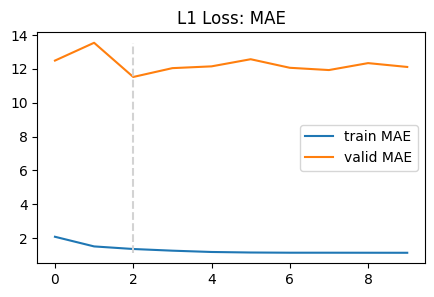

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
batch_s = 128
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
n_layers, hidden_dim, target_n = 3, 128, 17
model = Seq2Seq(n_layers, hidden_dim, att=False, target_n=17)
model = model.to(device)

lr = 0.001; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
myRNN1 = myTrain(trainloader, validloader, model, pm_label, pm_max=70)
myRNN1.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN1.loss_plot()
submit = pd.read_csv(root+'answer_sample.csv')
myRNN1.predict(model, testloader, submit, best_opt=True, last_opt=True)
myRNN1.last_submit.to_csv(root+'/output/0510_myrnn1_lastsubmit.csv', index=False)
myRNN1.best_submit.to_csv(root+'/output/0510_myrnn1_bestsubmit.csv', index=False)
# batch 128, lr 0.001, att=False

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 9/30


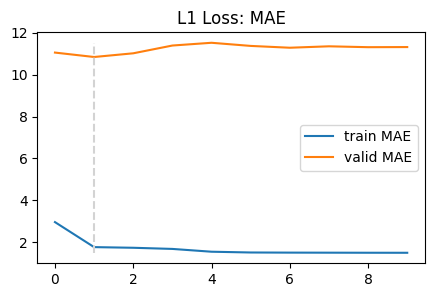

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
batch_s = 128
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
n_layers, hidden_dim, target_n = 3, 128, 17
model = Seq2Seq(n_layers, hidden_dim, att=True, target_n=17)
model = model.to(device)

lr = 0.0001; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
myRNN2 = myTrain(trainloader, validloader, model, pm_label, pm_max=70)
myRNN2.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN2.loss_plot()
submit = pd.read_csv(root+'answer_sample.csv')
myRNN2.predict(model, testloader, submit, best_opt=True, last_opt=True)
myRNN2.last_submit.to_csv(root+'/output/0510_myrnn2_lastsubmit.csv', index=False)
myRNN2.best_submit.to_csv(root+'/output/0510_myrnn2_bestsubmit.csv', index=False)
# batch 128, lr 0.0001, att=True

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 12/30


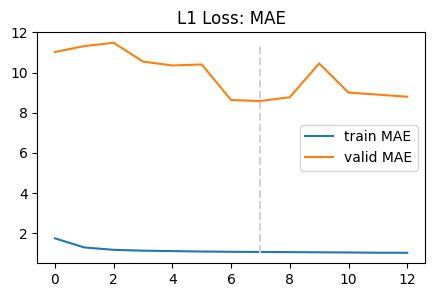

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
batch_s = 64
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
n_layers, hidden_dim, target_n = 3, 128, 17
model = Seq2Seq(n_layers, hidden_dim, att=True, target_n=17)
model = model.to(device)

lr = 0.001; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
myRNN3 = myTrain(trainloader, validloader, model, pm_label, pm_max=70)
myRNN3.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN3.loss_plot()
submit = pd.read_csv(root+'answer_sample.csv')
myRNN3.predict(model, testloader, submit, best_opt=True, last_opt=True)
myRNN3.last_submit.to_csv(root+'/output/0510_myrnn3_lastsubmit.csv', index=False)
myRNN3.best_submit.to_csv(root+'/output/0510_myrnn3_bestsubmit.csv', index=False)
# batch 64, lr 0.001, att=True

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 15/30


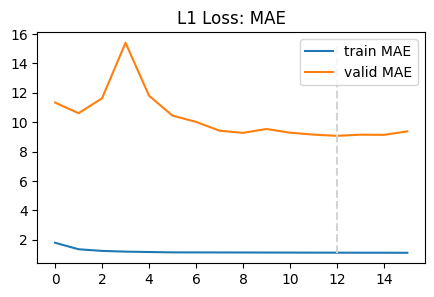

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
batch_s = 64
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
n_layers, hidden_dim, target_n = 3, 128, 17
model = Seq2Seq(n_layers, hidden_dim, att=True, dropout=0.3, target_n=17)
model = model.to(device)

lr = 0.001; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
myRNN4 = myTrain(trainloader, validloader, model, pm_label, pm_max=70)
myRNN4.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN4.loss_plot()
submit = pd.read_csv(root+'answer_sample.csv')
myRNN4.predict(model, testloader, submit, best_opt=True, last_opt=True)
myRNN4.last_submit.to_csv(root+'/output/0510_myrnn4_lastsubmit.csv', index=False)
myRNN4.best_submit.to_csv(root+'/output/0510_myrnn4_bestsubmit.csv', index=False)
# batch 64, lr 0.001, att=True, dropout=0.3

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 9/30


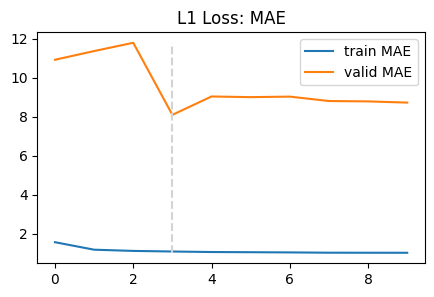

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
batch_s = 32
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
n_layers, hidden_dim, target_n = 3, 128, 17
model = Seq2Seq(n_layers, hidden_dim, att=True, dropout=0.2, target_n=17)
model = model.to(device)

lr = 0.001; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
myRNN5 = myTrain(trainloader, validloader, model, pm_label, pm_max=70)
myRNN5.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN5.loss_plot()
submit = pd.read_csv(root+'answer_sample.csv')
myRNN5.predict(model, testloader, submit, best_opt=True, last_opt=True)
myRNN5.last_submit.to_csv(root+'/output/0510_myrnn5_lastsubmit.csv', index=False)
myRNN5.best_submit.to_csv(root+'/output/0510_myrnn5_bestsubmit.csv', index=False)
# batch 32, lr 0.001, att=True, dropout=0.2

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 8/30


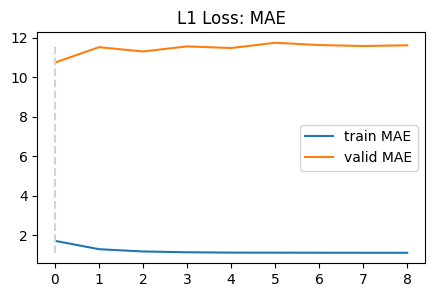

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
batch_s = 64
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
n_layers, hidden_dim, target_n = 3, 128, 17
model = Seq2Seq(n_layers, hidden_dim, att=True, dropout=0.2, target_n=17)
model = model.to(device)

lr = 0.001; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
myRNN6 = myTrain(trainloader, validloader, model, pm_label, pm_max=70)
myRNN6.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN6.loss_plot()
submit = pd.read_csv(root+'answer_sample.csv')
myRNN6.predict(model, testloader, submit, best_opt=True, last_opt=True)
myRNN6.last_submit.to_csv(root+'/output/0510_myrnn6_lastsubmit.csv', index=False)
myRNN6.best_submit.to_csv(root+'/output/0510_myrnn6_bestsubmit.csv', index=False)
# batch 64, lr 0.001, att=True, dropout=0.2, data fillna(bfill) 추가

Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/545 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.7553e-04.


  0%|          | 0/545 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0451e-04.


  0%|          | 0/545 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.9389e-04.


  0%|          | 0/545 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.5451e-04.


  0%|          | 0/545 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


  0%|          | 0/545 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4549e-04.


  0%|          | 0/545 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0611e-04.


  0%|          | 0/545 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.5492e-05.


  0%|          | 0/545 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4472e-05.


  0%|          | 0/545 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 0.0000e+00.


  0%|          | 0/545 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4472e-05.


  0%|          | 0/545 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.5492e-05.


  0%|          | 0/545 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0611e-04.


  0%|          | 0/545 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 13/30


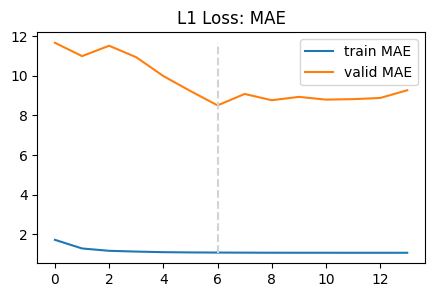

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
batch_s = 64
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
n_layers, hidden_dim, target_n = 3, 128, 17
model = Seq2Seq(n_layers, hidden_dim, att=True, dropout=0.2, target_n=17)
model = model.to(device)

lr = 0.001; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0, verbose=True)
myRNN7 = myTrain(trainloader, validloader, model, pm_label, pm_max=70)
myRNN7.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN7.loss_plot()
submit = pd.read_csv(root+'answer_sample.csv')
myRNN7.predict(model, testloader, submit, best_opt=True, last_opt=True)
myRNN7.last_submit.to_csv(root+'/output/0510_myrnn7_lastsubmit.csv', index=False)
myRNN7.best_submit.to_csv(root+'/output/0510_myrnn7_bestsubmit.csv', index=False)
# batch 64, lr 0.001, att=True, dropout=0.2, AdamW, cosine

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 15/30


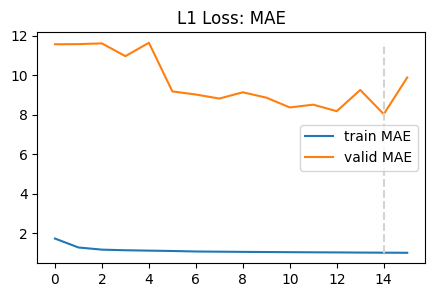

0it [00:00, ?it/s]

0it [00:00, ?it/s]

OSError: ignored

In [13]:
batch_s = 64
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
n_layers, hidden_dim, target_n = 3, 128, 17
model = Seq2Seq(n_layers, hidden_dim, att=True, dropout=0.2, target_n=17)
model = model.to(device)

lr = 0.001; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
myRNN8 = myTrain(trainloader, validloader, model, pm_label, pm_max=70)
myRNN8.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN8.loss_plot()
submit = pd.read_csv(root+'answer_sample.csv')
myRNN8.predict(model, testloader, submit, best_opt=True, last_opt=True)
myRNN8.last_submit.to_csv(root+'/output/0510_myrnn8_lastsubmit.csv', index=False)
myRNN8.best_submit.to_csv(root+'/output/0510_myrnn8_bestsubmit.csv', index=False)
# batch 64, lr 0.001, att=True, dropout=0.2, schedulerfac=0.5

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 1.0000e-07.


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

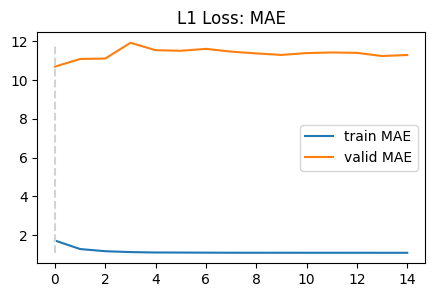

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [23]:
batch_s = 64
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
n_layers, hidden_dim, target_n = 3, 128, 17
model = Seq2Seq(n_layers, hidden_dim, att=True, dropout=0.2, target_n=17)
model = model.to(device)

lr = 0.001; epochs = 15; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
myRNN9 = myTrain(trainloader, validloader, model, pm_label, pm_max=70, earlystop=False)
myRNN9.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN9.loss_plot()
submit = pd.read_csv(root+'answer_sample.csv')
myRNN9.predict(model, testloader, submit, best_opt=True, last_opt=True)
myRNN9.last_submit.to_csv(root+'/output/0510_myrnn9_lastsubmit.csv', index=False)
myRNN9.best_submit.to_csv(root+'/output/0510_myrnn9_bestsubmit.csv', index=False)
# batch 64, lr 0.001, att=True, dropout=0.2, earlystopX

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 8/15


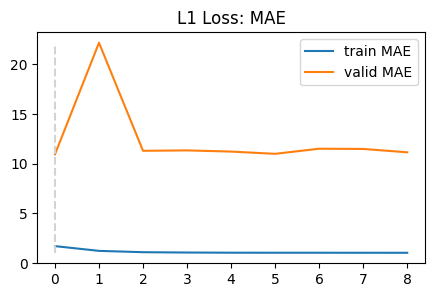

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [26]:
batch_s = 64
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
n_layers, hidden_dim, target_n = 3, 128, 17
model = Seq2Seq(n_layers, hidden_dim, att=True, dropout=0.1, target_n=17)
model = model.to(device)

lr = 0.001; epochs = 15; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
myRNN10 = myTrain(trainloader, validloader, model, pm_label, pm_max=70, earlystop=True)
myRNN10.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN10.loss_plot()
submit = pd.read_csv(root+'answer_sample.csv')
myRNN10.predict(model, testloader, submit, best_opt=True, last_opt=True)
myRNN10.last_submit.to_csv(root+'/output/0510_myrnn10_lastsubmit.csv', index=False)
myRNN10.best_submit.to_csv(root+'/output/0510_myrnn10_bestsubmit.csv', index=False)
# batch 64, lr 0.001, att=True, dropout=0.1

# class

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, en_hidden_dim, n_layers, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.en_hidden_dim = en_hidden_dim
        self.cnn1 = nn.Sequential(nn.Conv1d(input_dim, 50, 3, stride=1, padding=1),
                                  nn.SELU(),
                                  nn.Conv1d(50, 40, 3, stride=1, padding=1), 
                                  nn.BatchNorm1d(40), 
                                  nn.Dropout1d(dropout), nn.SELU(),
                                  nn.Conv1d(40, 30, 3, stride=1, padding=1), 
                                  nn.BatchNorm1d(30), nn.SELU(),
                                  nn.AvgPool1d(2, stride=2)) # 768,30,4
        self.cnn2 = nn.Sequential(nn.Conv1d(30,20,3, stride=1, padding=1),
                                  nn.BatchNorm1d(20), nn.SELU(),
                                  nn.Conv1d(20,17,3, stride=2, padding=1),
                                  nn.BatchNorm1d(17), nn.SELU(),
                                  nn.AvgPool1d(2, stride=2)) # 768,17,1
        self.lstm = nn.LSTM(input_dim, en_hidden_dim, n_layers, batch_first=True, dropout=dropout)
        
    def forward(self, en_input): # en_input: batch_s, times, channels, cols
        N,T,Ch,Co = en_input.shape # 16, 48, 17, 9
        en_input = en_input.reshape(N*T, Ch, Co) # 768, 17, 9
        cnn_output = self.cnn1(en_input) # 768, 30, 4
        cnn_output = self.cnn2(cnn_output) # 768, 17, 1
        cnn_output = cnn_output.reshape(N,T,-1) # 16, 48, 17
        en_hidden = self.init_hidden(N)
        en_output, en_hidden = self.lstm(cnn_output, en_hidden) # 16,48,128 / 3,16,128
        return en_output, en_hidden
    
    def init_hidden(self, batch_s):
        return (torch.zeros(self.n_layers, batch_s, self.en_hidden_dim, device=device),
               torch.zeros(self.n_layers, batch_s, self.en_hidden_dim, device=device))
        
class Attention(nn.Module):
    def __init__(self, en_hidden_dim, de_hidden_dim):
        super().__init__()
        self.fc_encoder = nn.Linear(en_hidden_dim, en_hidden_dim)
        self.fc_deinput = nn.Linear(de_hidden_dim, de_hidden_dim)
        self.scoring = nn.Linear(en_hidden_dim, 1)
        
    def forward(self, en_output, de_input):
        fc_en = self.fc_encoder(en_output) # 16,48,128
        fc_de = self.fc_deinput(de_input.unsqueeze(1)) # 16,1,128
        score = self.scoring(torch.tanh(fc_en+fc_de)) # 16,48,1
        att_w = torch.softmax(score, axis=1) # 16,48,1
        cont_v = att_w * en_output # 16,48,128
        cont_v = torch.sum(cont_v, dim=1) # 16,128
        return cont_v, att_w

class Decoder(nn.Module):
    def __init__(self, de_input_s, en_hidden_dim, de_hidden_dim, output_dim,
                 n_layers, dropout, att=False):
        super().__init__()
        self.n_layers, self.de_hidden_dim = n_layers, de_hidden_dim
        self.output_dim = output_dim
        if att:
            self.attention = Attention(en_hidden_dim=en_hidden_dim, de_hidden_dim=de_hidden_dim)
            self.lstm = nn.LSTM(en_hidden_dim*2, de_hidden_dim, n_layers, dropout=dropout)
        else: 
            self.attention = None
            self.lstm = nn.LSTM(en_hidden_dim, de_hidden_dim, n_layers, dropout=dropout)
        
        self.layer = nn.Linear(de_input_s, en_hidden_dim)
        # self.lstm = nn.LSTM(en_hidden_dim*2, de_hidden_dim, n_layers, dropout=dropout)
        self.fc = nn.Linear(de_hidden_dim, output_dim)
        
    def forward(self, en_output, de_input, de_hidden):
        N,_ = de_input.shape # 16,17
        de_input = self.layer(de_input) # 16,128
        if self.attention is not None:
            cont_v, att_w = self.attention(en_output, de_input)
            de_input = torch.cat([cont_v, de_input], dim=1) # 16,256
        de_input = de_input.unsqueeze(0) # 1,16,256
        de_hidden = self.init_hidden(N)
        de_output, de_hidden = self.lstm(de_input, de_hidden) # 1,16,128 / 3,16,128
        de_output = de_output.sum(0) # 16,128
        de_output = self.fc(de_output) # 16,17
        return de_output, de_hidden

    def init_hidden(self, batch_s):
        return (torch.zeros(self.n_layers, batch_s, self.de_hidden_dim, device=device),
               torch.zeros(self.n_layers, batch_s, self.de_hidden_dim, device=device))
        
class Seq2Seq(nn.Module):
    def __init__(self, n_layers, hidden_dim, att=False, dropout=0.2, target_n=17):
        super().__init__()
        self.encoder = Encoder(input_dim=target_n, en_hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout)
        self.decoder = Decoder(de_input_s=target_n, en_hidden_dim=hidden_dim, de_hidden_dim=hidden_dim,
                        output_dim=target_n, n_layers=n_layers, dropout=dropout, att=att)
        
    def forward(self, en_input, decoder_input, training=True):
        N,T,target_n = decoder_input.shape # 16,73,17
        outputs = torch.zeros(N, T-1, target_n).to(device) # 16,72,17
        en_output, en_hidden = self.encoder(en_input)
        de_input = decoder_input[:,0] # 16,17
        for t in range(0, T-1):
            if t==0: de_hidden = en_hidden
            de_output, de_hidden = self.decoder(en_output, de_input, de_hidden)
            outputs[:,t] = de_output # 16,17
            if training:
                de_input = decoder_input[:,t+1]
            else:
                de_input = de_output
        return outputs

In [22]:
class myTrain():
    def __init__(self, trainloader, validloader, model, pm_label, pm_max=70, earlystop=True, de_window_s=3*24, target_n=17):
        self.trainloader, self.validloader = trainloader, validloader
        self.model = model
        self.save_best_pth, self.save_last_pth = 'best_checkpoint.pth', 'last_checkpoint.pth'
        self.pm_label, self.pm_max = pm_label, pm_max
        self.earlystop = earlystop

    def train_loop(self, epochs, loss_fn, optimizer, scheduler, patience):
        self.train_loss_li, self.valid_loss_li = [], []
        trigger = 0
        for epoch in range(epochs):
            self.model.train()
            train_loss = []
            train_tqdm = tqdm(self.trainloader)
            for batch in train_tqdm:
                encoder_input = batch['encoder_input'].to(device)
                decoder_input = batch['decoder_input'].to(device)
                output = self.model(encoder_input, decoder_input, training=True)
                loss = loss_fn(output, decoder_input[:,1:])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())

                train_tqdm.set_postfix({'Epoch':epoch,
                                        'Loss':'{:.3f}'.format(train_loss[-1]*self.pm_max),
                                        'meanLoss':'{:.3f}'.format(np.mean(train_loss)*self.pm_max)})
            self.train_loss_li.append(np.mean(train_loss)*self.pm_max)
            self.valid_loss_li.append(self.validate(loss_fn)*self.pm_max)
            
            if np.min(self.valid_loss_li)==self.valid_loss_li[-1]:
                best_state = deepcopy(self.model.state_dict())
                torch.save(best_state, self.save_best_pth)
                self.best_epoch = epoch
                tigger = 0
            else:
                trigger += 1
                if self.earlystop:
                    if trigger>patience:
                        print('\nEarly Stopping!! epoch/epochs: {}/{}'.format(epoch, epochs))
                        break
            scheduler.step(self.valid_loss_li[-1])
            
        last_state = deepcopy(self.model.state_dict())
        torch.save(last_state, self.save_last_pth)

    def validate(self, loss_fn):
        self.valid_output = []
        self.model.eval()
        valid_loss = []
        # valid_tqdm = tqdm(self.validloader)
        valid_tqdm = self.validloader
        with torch.no_grad():
            for batch in valid_tqdm:
                encoder_input = batch['encoder_input'].to(device)
                decoder_input = batch['decoder_input'].to(device)
                output = self.model(encoder_input, decoder_input, training=False)
                loss = loss_fn(output, decoder_input[:,1:]).item()
                valid_loss.append(loss)
                # valid_tqdm.set_postfix({'ValidLoss':'{:.3f}'.format(valid_loss[-1]),
                #                         'meanValidLoss':'{:.3f}'.format(np.mean(valid_loss))})
                self.valid_output += output
        return np.mean(valid_loss)

    def loss_plot(self):
        fig, ax = plt.subplots(figsize=(5,3))
        ax.plot(self.train_loss_li, label='train MAE')
        ax.plot(self.valid_loss_li, label='valid MAE')
        ax.vlines(self.best_epoch, min(self.train_loss_li), max(self.valid_loss_li), colors='lightgray', linestyle='--')
        plt.title('L1 Loss: MAE'); plt.legend()
        plt.show()

    def evaluate(self, model, testloader, submit):
        model.eval()
        batch_s = next(iter(testloader))['encoder_input'].shape[0]
        preds = torch.zeros(batch_s*de_window_s, len(testloader), target_n)
        test_tqdm = tqdm(enumerate(testloader))
        with torch.no_grad():
            for i,batch in test_tqdm:
                encoder_input = batch['encoder_input'].to(device)
                decoder_input = torch.zeros([batch_s,de_window_s+1, target_n], dtype=torch.float32).to(device)
                output = model(encoder_input, decoder_input, training=False)
                preds[:,i] = output.view(-1, target_n)
        preds = preds.view(-1, target_n).cpu()
        for i,pm_loc in enumerate(self.pm_label):
            submit.loc[submit['측정소']==pm_loc, 'PM2.5'] = preds[:,i].numpy().tolist()
        return submit 

    def predict(self, model, testloader, submit, best_opt=True, last_opt=True):
        if best_opt:
            best_dict = torch.load(self.save_best_pth)
            best_model = model
            best_model.load_state_dict(best_dict)
            self.best_submit = self.evaluate(best_model, testloader, submit)
        if last_opt:
            last_dict = torch.load(self.save_last_pth)
            last_model = model
            last_model.load_state_dict(last_dict)
            self.last_submit = self.evaluate(last_model, testloader, submit)